# 정규화

딥러닝을 하는데 충분한 데이터로 학습하지 않을 경우 과적합 문제가 발생 할 수 있습니다.

물론 학습데이터에 대해 잘 학습해야합니다. 하지만 학습데이터에서 보지 못한 새로운 데이터에 대해서도 대응 할 수 있어야합니다.


**이번에 배울 내용!!:** 정규화를 사용한 딥러닝 모델.

In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
from reg_utils import sigmoid, relu, plot_decision_boundary, initialize_parameters, load_2D_dataset, predict_dec
from reg_utils import compute_cost, predict, forward_propagation, backward_propagation, update_parameters
import sklearn
import sklearn.datasets
import scipy.io
from testCases import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

**Problem Statement**:   
프랑스 축구 팀에서 AI 전문가로 당신을 고용했다고 가정해봅시다.

그리고 축구팀은 골키퍼가 공을 찰때 어느 위치가 공을 받기에 좋은지를 알고싶어합니다.

<img src="images/field_kiank.png" style="width:600px;height:350px;">
<caption><center> <u> **Figure 1** </u>: **Football field**<br> 골키퍼가 공을 찼을때 각 팀원들은 머리로 공을 받기 위해 몸싸움을 합니다. </center></caption>

분석을 위해 축구팀은 각 10게임에 대한 2D 데이터를 제공해줬습니다.

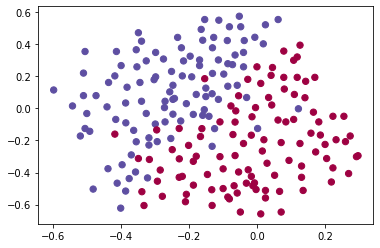

In [2]:
train_X, train_Y, test_X, test_Y = load_2D_dataset()

각 점들은 왼쪽에서 골키퍼가 공을 찼을때 선수들이 공을 받은 위치입니다.

- 파란색 점은 프랑스 팀 선수가 공을 받은 위치입니다.
- 빨간색 점은 상대 팀 선수가 공을 받은 위치입니다.


**이번 목표**: 딥러닝 모델을 통해 골키퍼가 어디로 차야 좋은지 알아봅시다.


**데이터 셋 해석**: 
왼쪽 위 부분은 대부분 파란색이고 오른쪽 아래 부분은 대부분 빨간색으로 구분할 수 있습니다. 하지만 대부분으로 일부 다른 색상이 나오기는 합니다.

일단 정규화 하지 않은 모델을 사용해보고 이후에 정규화에 대해 공부하고 프랑스 팀을 위해 문제 해결 해봅시다.

예전에 실행했던 신경망을 사용할겁니다.:
You will use the following neural network (already implemented for you below). This model can be used:

- 정규화 모드에서는 lambd 를 0이 아닌 값으로 설정합니다. 그리고 `lambda`는 파이썬에 기본적으로 제공하는 기능으로 겹치기 때문에 `lambda` 대신에 `lambd`를 사용할 겁니다.
- dropout 모드에서는 `keep_prob`을 1보다 작은 값으로 설정합니다.


일단은 정규화를 사용하지 않고 진행합니다. 이후에 다음 방법을 사용해 볼겁니다:
- *L2 regularization* 의 기능으로: "`compute_cost_with_regularization()`"와 "`backward_propagation_with_regularization()`"
- *Dropout* 의 기능으로: "`forward_propagation_with_dropout()`" 와 "`backward_propagation_with_dropout()`"


## 1 - 비정규화 모델

In [3]:
def model(X, Y, learning_rate = 0.3, num_iterations = 30000, print_cost = True, lambd = 0, keep_prob = 1):
    """
    Implements a three-layer neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (output size, number of examples)
    learning_rate -- learning rate of the optimization
    num_iterations -- number of iterations of the optimization loop
    print_cost -- If True, print the cost every 10000 iterations
    lambd -- regularization hyperparameter, scalar
    keep_prob - probability of keeping a neuron active during drop-out, scalar.
    
    Returns:
    parameters -- parameters learned by the model. They can then be used to predict.
    """
        
    grads = {}
    costs = []                            # to keep track of the cost
    m = X.shape[1]                        # number of examples
    layers_dims = [X.shape[0], 20, 3, 1]
    
    # Initialize parameters dictionary.
    parameters = initialize_parameters(layers_dims)

    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
        if keep_prob == 1:
            a3, cache = forward_propagation(X, parameters)
        elif keep_prob < 1:
            a3, cache = forward_propagation_with_dropout(X, parameters, keep_prob)
        
        # Cost function
        if lambd == 0:
            cost = compute_cost(a3, Y)
        else:
            cost = compute_cost_with_regularization(a3, Y, parameters, lambd)
            
        # Backward propagation.
        assert(lambd==0 or keep_prob==1)    # it is possible to use both L2 regularization and dropout, 
                                            # but this assignment will only explore one at a time
        if lambd == 0 and keep_prob == 1:
            grads = backward_propagation(X, Y, cache)
        elif lambd != 0:
            grads = backward_propagation_with_regularization(X, Y, cache, lambd)
        elif keep_prob < 1:
            grads = backward_propagation_with_dropout(X, Y, cache, keep_prob)
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Print the loss every 10000 iterations
        if print_cost and i % 10000 == 0:
            print("Cost after iteration {}: {}".format(i, cost))
        if print_cost and i % 1000 == 0:
            costs.append(cost)
    
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (x1,000)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

정규화 없이 학습시켜봅시다. 그리고 정확도를 보죠

Cost after iteration 0: 0.6557412523481002
Cost after iteration 10000: 0.1632998752572419
Cost after iteration 20000: 0.13851642423239133


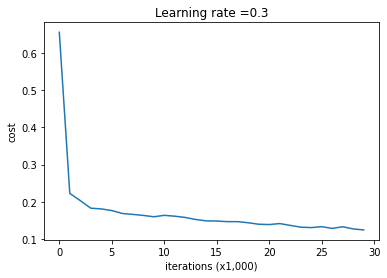

On the training set:
Accuracy: 0.9478672985781991
On the test set:
Accuracy: 0.915


In [4]:
parameters = model(train_X, train_Y)
print ("On the training set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

학습데이터에 대한 정확도는 94.8% 이지만 검정데이터에 대한 정확도는 91.5% 입니다.   
일단 이 정확도를 **기준점**으로 삼고 비교해봅시다. 아래 코드를 실행시켜 결정경계가 어떻게 생겼는지 확인해봅시다.

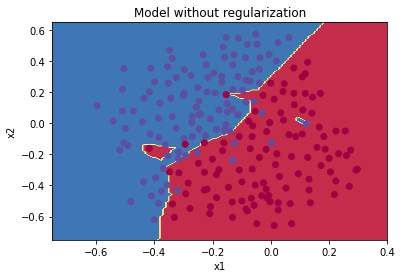

In [5]:
plt.title("Model without regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

비정규화 모델은 학습데이터에 대해 어느정도 과적합한 모습을 보입니다.
 
과적합의 기준으로 완벽하게 대각선을 보이지 않고 특이한 지점 까지 학습한 모습을 보시면 됩니다.

과적합을 줄이는 2가지 방법을 알아봅시다.


## 2 - L2 Regularization

일반적으로 과적합을 피하기 위해 사용하는 정규화 방법으로 **L2 regularization**를 사용합니다.

이 방법은 적절하게 비용함수 값을 조정해줍니다.    
  
**기존** 비용함수 수식:  
$$J = -\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small  y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} \tag{1}$$  
**정규화 된** 비용함수 수식:  
$$J_{regularized} = \small \underbrace{-\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} }_\text{cross-entropy cost} + \underbrace{\frac{1}{m} \frac{\lambda}{2} \sum\limits_l\sum\limits_k\sum\limits_j W_{k,j}^{[l]2} }_\text{L2 regularization cost} \tag{2}$$

비용함수를 수정하고 어떻게 결과가 바뀌는지 확인해봅시다.

**Exercise**: `compute_cost_with_regularization()` 를 사용해 정규화 된 비용함수 수식을 구현해보세요.   
  
$\sum\limits_k\sum\limits_j W_{k,j}^{[l]2}$ 를 계산하기 위해서는 다음 코드를 사용하세요:
```python
np.sum(np.square(Wl))
```

In [6]:
# GRADED FUNCTION: compute_cost_with_regularization

def compute_cost_with_regularization(A3, Y, parameters, lambd):
    """
    Implement the cost function with L2 regularization. See formula (2) above.
    
    Arguments:
    A3 -- post-activation, output of forward propagation, of shape (output size, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    parameters -- python dictionary containing parameters of the model
    
    Returns:
    cost - value of the regularized loss function (formula (2))
    """
    m = Y.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]
    
    cross_entropy_cost = compute_cost(A3, Y) # This gives you the cross-entropy part of the cost
    
    L2_regularization_cost = lambd * (np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3))) / (2 * m)
    
    cost = cross_entropy_cost + L2_regularization_cost
    
    return cost

In [7]:
A3, Y_assess, parameters = compute_cost_with_regularization_test_case()

print("cost = " + str(compute_cost_with_regularization(A3, Y_assess, parameters, lambd = 0.1)))

cost = 1.7864859451590758


**Expected Output**: 

<table> 
    <tr>
    <td>
    **cost**
    </td>
        <td>
    1.78648594516
    </td>
    </tr>
</table> 

비용함수 수식을 변경했기 때문에 역전파도 약간 변화해야합니다. 모든 변화도는 새로운 비용함수 값에 영향을 받아 계산합니다.


**Exercise**: 
정규화로 인해 역전파에 필요한 변화를 적용시켜보세요

변해야할 대상은 dW1, dW2 and dW3 뿐입니다.

각각에 정규화로 생긴 수식들을 추가해줍니다. ($\frac{d}{dW} ( \frac{1}{2}\frac{\lambda}{m}  W^2) = \frac{\lambda}{m} W$).

In [8]:
# GRADED FUNCTION: backward_propagation_with_regularization

def backward_propagation_with_regularization(X, Y, cache, lambd):
    """
    Implements the backward propagation of our baseline model to which we added an L2 regularization.
    
    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    cache -- cache output from forward_propagation()
    lambd -- regularization hyperparameter, scalar
    
    Returns:
    gradients -- A dictionary with the gradients with respect to each parameter, activation and pre-activation variables
    """
    
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 =  1. / m * np.dot(dZ3, A2.T) + (lambd * W3) / m
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T) + (lambd * W2) / m
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T) + (lambd * W1) / m
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

In [9]:
X_assess, Y_assess, cache = backward_propagation_with_regularization_test_case()

grads = backward_propagation_with_regularization(X_assess, Y_assess, cache, lambd = 0.7)
print ("dW1 = \n"+ str(grads["dW1"]))
print ("dW2 = \n"+ str(grads["dW2"]))
print ("dW3 = \n"+ str(grads["dW3"]))

dW1 = 
[[-0.25604646  0.12298827 -0.28297129]
 [-0.17706303  0.34536094 -0.4410571 ]]
dW2 = 
[[ 0.79276486  0.85133918]
 [-0.0957219  -0.01720463]
 [-0.13100772 -0.03750433]]
dW3 = 
[[-1.77691347 -0.11832879 -0.09397446]]


**Expected Output**:

```
dW1 = 
[[-0.25604646  0.12298827 -0.28297129]
 [-0.17706303  0.34536094 -0.4410571 ]]
dW2 = 
[[ 0.79276486  0.85133918]
 [-0.0957219  -0.01720463]
 [-0.13100772 -0.03750433]]
dW3 = 
[[-1.77691347 -0.11832879 -0.09397446]]
```

이제 L2 정규화를 적용시킨 모델을 학습시켜봅시다. $(\lambda = 0.7)$.

우리가 사용할 `model()`은 다음 기능이 변했습니다:
- `compute_cost` 대신에 `compute_cost_with_regularization` 
- `backward_propagation` 대신에 `backward_propagation_with_regularization` 

Cost after iteration 0: 0.6974484493131264
Cost after iteration 10000: 0.2684918873282239
Cost after iteration 20000: 0.2680916337127301


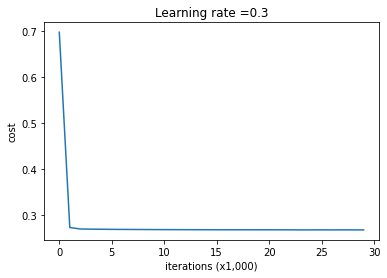

On the train set:
Accuracy: 0.9383886255924171
On the test set:
Accuracy: 0.93


In [10]:
parameters = model(train_X, train_Y, lambd = 0.7)
print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

검정데이터에 대한 정확도가 93%가 됐습니다.

과적합을 상당히 많이 줄였네요 결정경께 까지 확인해보죠!

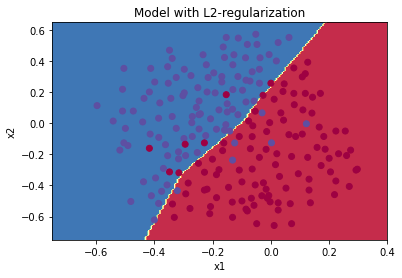

In [11]:
plt.title("Model with L2-regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

**관찰 결과**:
- $\lambda$ 은 하이퍼 파라미터로 잘 조절해야합니다.

- 만약 $\lambda$ 값이 너무 크다면 잘못 예측하는 결과가 나타나도록 너무 부드럽게 만들어 줄겁니다


**L2 정규화가 실제로 하는 일?**:

L2 정규화는 가중치가 큰 모델보다 작은 모델이 더 간단한 모델이라는 가정을 합니다.

그러므로 비용함수 값에 제곱을 적용하면 가중치 값들이 더 작아지도록 만듭니다.

큰 가중치를 갖고있으면 비용 또한 커집니다. 정규화를 통해 강제적으로 가중치 값을 작게 만들었습니다. 그래서 모델이 이상치에 크게 반응하지 못하게 됩니다.


<font color='blue'>  
**기억해야할 점** -- the implications of L2-regularization on:  
- 비용함수 계산:  
    - 정규화가 비용함수 계산하는데 적용됩니다.  
- 역전파:  
    - 변화량을 구하기 위해 비용함수가 정규화에 영향을 받은 것 처럼 미분값에 영향을 끼칩니다.  
- 가중치 값들은 서서히 줄어듭니다 ("weight decay"):   
    - 가중치 값들은 작은 값을 갖게 됩니다.  

## 3 - Dropout

각 학습 마다 랜덤하게 일부 노드 또는 뉴런에 계산을 안합니다.

<!--
To understand drop-out, consider this conversation with a friend:
- Friend: "Why do you need all these neurons to train your network and classify images?". 
- You: "Because each neuron contains a weight and can learn specific features/details/shape of an image. The more neurons I have, the more featurse my model learns!"
- Friend: "I see, but are you sure that your neurons are learning different features and not all the same features?"
- You: "Good point... Neurons in the same layer actually don't talk to each other. It should be definitly possible that they learn the same image features/shapes/forms/details... which would be redundant. There should be a solution."
!--> 


<center>
<video width="620" height="440" src="images/dropout1_kiank.mp4" type="video/mp4" controls>
</video>
</center>
<br>
<caption><center> <u> Figure 2 </u>: Drop-out on the second hidden layer. <br> At each iteration, you shut down (= set to zero) each neuron of a layer with probability $1 - keep\_prob$ or keep it with probability $keep\_prob$ (50% here). The dropped neurons don't contribute to the training in both the forward and backward propagations of the iteration. </center></caption>

<center>
<video width="620" height="440" src="images/dropout2_kiank.mp4" type="video/mp4" controls>
</video>
</center>

<caption><center> <u> Figure 3 </u>: Drop-out on the first and third hidden layers. <br> $1^{st}$ layer: we shut down on average 40% of the neurons.  $3^{rd}$ layer: we shut down on average 20% of the neurons. </center></caption>


When you shut some neurons down, you actually modify your model. The idea behind drop-out is that at each iteration, you train a different model that uses only a subset of your neurons. With dropout, your neurons thus become less sensitive to the activation of one other specific neuron, because that other neuron might be shut down at any time. 

### 3.1 - Forward propagation with dropout

**Exercise**: Implement the forward propagation with dropout. You are using a 3 layer neural network, and will add dropout to the first and second hidden layers. We will not apply dropout to the input layer or output layer. 

**Instructions**:
You would like to shut down some neurons in the first and second layers. To do that, you are going to carry out 4 Steps:
1. In lecture, we dicussed creating a variable $d^{[1]}$ with the same shape as $a^{[1]}$ using `np.random.rand()` to randomly get numbers between 0 and 1. Here, you will use a vectorized implementation, so create a random matrix $D^{[1]} = [d^{[1](1)} d^{[1](2)} ... d^{[1](m)}] $ of the same dimension as $A^{[1]}$.
2. Set each entry of $D^{[1]}$ to be 1 with probability (`keep_prob`), and 0 otherwise.

**Hint:** Let's say that keep_prob = 0.8, which means that we want to keep about 80% of the neurons and drop out about 20% of them.  We want to generate a vector that has 1's and 0's, where about 80% of them are 1 and about 20% are 0.
This python statement:  
`X = (X < keep_prob).astype(int)`  

is conceptually the same as this if-else statement (for the simple case of a one-dimensional array) :

```
for i,v in enumerate(x):
    if v < keep_prob:
        x[i] = 1
    else: # v >= keep_prob
        x[i] = 0
```
Note that the `X = (X < keep_prob).astype(int)` works with multi-dimensional arrays, and the resulting output preserves the dimensions of the input array.

Also note that without using `.astype(int)`, the result is an array of booleans `True` and `False`, which Python automatically converts to 1 and 0 if we multiply it with numbers.  (However, it's better practice to convert data into the data type that we intend, so try using `.astype(int)`.)

3. Set $A^{[1]}$ to $A^{[1]} * D^{[1]}$. (You are shutting down some neurons). You can think of $D^{[1]}$ as a mask, so that when it is multiplied with another matrix, it shuts down some of the values.
4. Divide $A^{[1]}$ by `keep_prob`. By doing this you are assuring that the result of the cost will still have the same expected value as without drop-out. (This technique is also called inverted dropout.)

In [13]:
# GRADED FUNCTION: forward_propagation_with_dropout

def forward_propagation_with_dropout(X, parameters, keep_prob = 0.5):
    """
    Implements the forward propagation: LINEAR -> RELU + DROPOUT -> LINEAR -> RELU + DROPOUT -> LINEAR -> SIGMOID.
    
    Arguments:
    X -- input dataset, of shape (2, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3":
                    W1 -- weight matrix of shape (20, 2)
                    b1 -- bias vector of shape (20, 1)
                    W2 -- weight matrix of shape (3, 20)
                    b2 -- bias vector of shape (3, 1)
                    W3 -- weight matrix of shape (1, 3)
                    b3 -- bias vector of shape (1, 1)
    keep_prob - probability of keeping a neuron active during drop-out, scalar
    
    Returns:
    A3 -- last activation value, output of the forward propagation, of shape (1,1)
    cache -- tuple, information stored for computing the backward propagation
    """
    
    np.random.seed(1)
    
    # retrieve parameters
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    ### START CODE HERE ### (approx. 4 lines)        # Steps 1-4 below correspond to the Steps 1-4 described above. 
    D1 = np.random.rand(A1.shape[0], A1.shape[1])    # Step 1: initialize matrix D1 = np.random.rand(..., ...)
    D1 = D1 < keep_prob                              # Step 2: convert entries of D1 to 0 or 1 (using keep_prob as the threshold)
    A1 = A1 * D1                                     # Step 3: shut down some neurons of A1
    A1 = A1 / keep_prob                              # Step 4: scale the value of neurons that haven't been shut down
    ### END CODE HERE ###
    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)
    ### START CODE HERE ### (approx. 4 lines)
    D2 = np.random.rand(A2.shape[0], A2.shape[1])    # Step 1: initialize matrix D2 = np.random.rand(..., ...)
    D2 = D2 < keep_prob                              # Step 2: convert entries of D2 to 0 or 1 (using keep_prob as the threshold)
    A2 = A2 * D2                                     # Step 3: shut down some neurons of A2
    A2 = A2 / keep_prob                              # Step 4: scale the value of neurons that haven't been shut down
    ### END CODE HERE ###
    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)
    
    cache = (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3)
    
    return A3, cache

In [14]:
X_assess, parameters = forward_propagation_with_dropout_test_case()

A3, cache = forward_propagation_with_dropout(X_assess, parameters, keep_prob = 0.7)
print ("A3 = " + str(A3))

A3 = [[ 0.36974721  0.00305176  0.04565099  0.49683389  0.36974721]]


In [16]:
parameters

{'W1': array([[-1.09989127, -0.17242821, -0.87785842],
        [ 0.04221375,  0.58281521, -1.10061918]]),
 'W2': array([[ 0.50249434,  0.90085595],
        [-0.68372786, -0.12289023],
        [-0.93576943, -0.26788808]]),
 'W3': array([[-0.6871727 , -0.84520564, -0.67124613]]),
 'b1': array([[ 1.14472371],
        [ 0.90159072]]),
 'b2': array([[ 0.53035547],
        [-0.69166075],
        [-0.39675353]]),
 'b3': array([[-0.0126646]])}

**Expected Output**: 

<table> 
    <tr>
    <td>
    **A3**
    </td>
        <td>
    [[ 0.36974721  0.00305176  0.04565099  0.49683389  0.36974721]]
    </td>
    
    </tr>

</table> 

### 3.2 - Backward propagation with dropout

**Exercise**: Implement the backward propagation with dropout. As before, you are training a 3 layer network. Add dropout to the first and second hidden layers, using the masks $D^{[1]}$ and $D^{[2]}$ stored in the cache. 

**Instruction**:
Backpropagation with dropout is actually quite easy. You will have to carry out 2 Steps:
1. You had previously shut down some neurons during forward propagation, by applying a mask $D^{[1]}$ to `A1`. In backpropagation, you will have to shut down the same neurons, by reapplying the same mask $D^{[1]}$ to `dA1`. 
2. During forward propagation, you had divided `A1` by `keep_prob`. In backpropagation, you'll therefore have to divide `dA1` by `keep_prob` again (the calculus interpretation is that if $A^{[1]}$ is scaled by `keep_prob`, then its derivative $dA^{[1]}$ is also scaled by the same `keep_prob`).


In [17]:
# GRADED FUNCTION: backward_propagation_with_dropout

def backward_propagation_with_dropout(X, Y, cache, keep_prob):
    """
    Implements the backward propagation of our baseline model to which we added dropout.
    
    Arguments:
    X -- input dataset, of shape (2, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    cache -- cache output from forward_propagation_with_dropout()
    keep_prob - probability of keeping a neuron active during drop-out, scalar
    
    Returns:
    gradients -- A dictionary with the gradients with respect to each parameter, activation and pre-activation variables
    """
    
    m = X.shape[1]
    (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = 1./m * np.dot(dZ3, A2.T)
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    dA2 = np.dot(W3.T, dZ3)
    ### START CODE HERE ### (≈ 2 lines of code)
    dA2 = dA2 * D2                # Step 1: Apply mask D2 to shut down the same neurons as during the forward propagation
    dA2 = dA2 / keep_prob         # Step 2: Scale the value of neurons that haven't been shut down
    ### END CODE HERE ###
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T)
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)
    ### START CODE HERE ### (≈ 2 lines of code)
    dA1 = dA1 * D1              # Step 1: Apply mask D1 to shut down the same neurons as during the forward propagation
    dA1 = dA1 / keep_prob       # Step 2: Scale the value of neurons that haven't been shut down
    ### END CODE HERE ###
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T)
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

In [18]:
X_assess, Y_assess, cache = backward_propagation_with_dropout_test_case()

gradients = backward_propagation_with_dropout(X_assess, Y_assess, cache, keep_prob = 0.8)

print ("dA1 = \n" + str(gradients["dA1"]))
print ("dA2 = \n" + str(gradients["dA2"]))

dA1 = 
[[ 0.36544439  0.         -0.00188233  0.         -0.17408748]
 [ 0.65515713  0.         -0.00337459  0.         -0.        ]]
dA2 = 
[[ 0.58180856  0.         -0.00299679  0.         -0.27715731]
 [ 0.          0.53159854 -0.          0.53159854 -0.34089673]
 [ 0.          0.         -0.00292733  0.         -0.        ]]


**Expected Output**: 

```
dA1 = 
[[ 0.36544439  0.         -0.00188233  0.         -0.17408748]
 [ 0.65515713  0.         -0.00337459  0.         -0.        ]]
dA2 = 
[[ 0.58180856  0.         -0.00299679  0.         -0.27715731]
 [ 0.          0.53159854 -0.          0.53159854 -0.34089673]
 [ 0.          0.         -0.00292733  0.         -0.        ]]
```

Let's now run the model with dropout (`keep_prob = 0.86`). It means at every iteration you shut down each neurons of layer 1 and 2 with 14% probability. The function `model()` will now call:
- `forward_propagation_with_dropout` instead of `forward_propagation`.
- `backward_propagation_with_dropout` instead of `backward_propagation`.

Cost after iteration 0: 0.6543912405149825


/home/jovyan/work/week5/Regularization/reg_utils.py:236: RuntimeWarning: divide by zero encountered in log
  logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)
/home/jovyan/work/week5/Regularization/reg_utils.py:236: RuntimeWarning: invalid value encountered in multiply
  logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)


Cost after iteration 10000: 0.06101698657490562
Cost after iteration 20000: 0.060582435798513114


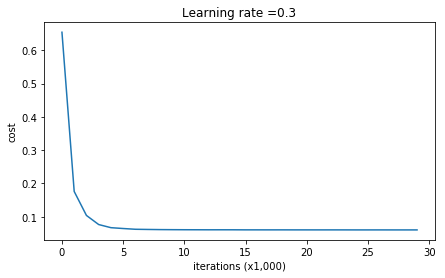

On the train set:
Accuracy: 0.928909952607
On the test set:
Accuracy: 0.95


In [19]:
parameters = model(train_X, train_Y, keep_prob = 0.86, learning_rate = 0.3)

print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

Dropout works great! The test accuracy has increased again (to 95%)! Your model is not overfitting the training set and does a great job on the test set. The French football team will be forever grateful to you! 

Run the code below to plot the decision boundary.

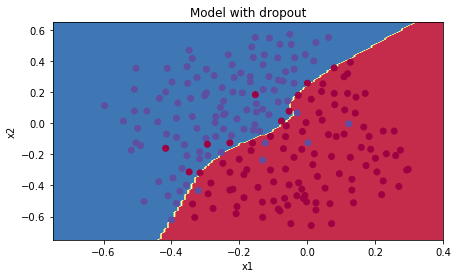

In [20]:
plt.title("Model with dropout")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

**Note**:
- A **common mistake** when using dropout is to use it both in training and testing. You should use dropout (randomly eliminate nodes) only in training. 
- Deep learning frameworks like [tensorflow](https://www.tensorflow.org/api_docs/python/tf/nn/dropout), [PaddlePaddle](http://doc.paddlepaddle.org/release_doc/0.9.0/doc/ui/api/trainer_config_helpers/attrs.html), [keras](https://keras.io/layers/core/#dropout) or [caffe](http://caffe.berkeleyvision.org/tutorial/layers/dropout.html) come with a dropout layer implementation. Don't stress - you will soon learn some of these frameworks.

<font color='blue'>
**What you should remember about dropout:**
- Dropout is a regularization technique.
- You only use dropout during training. Don't use dropout (randomly eliminate nodes) during test time.
- Apply dropout both during forward and backward propagation.
- During training time, divide each dropout layer by keep_prob to keep the same expected value for the activations. For example, if keep_prob is 0.5, then we will on average shut down half the nodes, so the output will be scaled by 0.5 since only the remaining half are contributing to the solution. Dividing by 0.5 is equivalent to multiplying by 2. Hence, the output now has the same expected value. You can check that this works even when keep_prob is other values than 0.5.  

## 4 - Conclusions

**Here are the results of our three models**: 

<table> 
    <tr>
        <td>
        **model**
        </td>
        <td>
        **train accuracy**
        </td>
        <td>
        **test accuracy**
        </td>

    </tr>
        <td>
        3-layer NN without regularization
        </td>
        <td>
        95%
        </td>
        <td>
        91.5%
        </td>
    <tr>
        <td>
        3-layer NN with L2-regularization
        </td>
        <td>
        94%
        </td>
        <td>
        93%
        </td>
    </tr>
    <tr>
        <td>
        3-layer NN with dropout
        </td>
        <td>
        93%
        </td>
        <td>
        95%
        </td>
    </tr>
</table> 

Note that regularization hurts training set performance! This is because it limits the ability of the network to overfit to the training set. But since it ultimately gives better test accuracy, it is helping your system. 

Congratulations for finishing this assignment! And also for revolutionizing French football. :-) 

<font color='blue'>
**What we want you to remember from this notebook**:
- Regularization will help you reduce overfitting.
- Regularization will drive your weights to lower values.
- L2 regularization and Dropout are two very effective regularization techniques.